## Toeplitz Example

Here we demonstrate an application of Toeplitz embedding with TorchKbNufft. For a NUFFT matrix F, the operation F'F is block Toeplitz with Toeplitz blocks. Such a matrix can be embedded into a circulant matrix, which allows its evaluation with only FFTs (i.e., no interpolations) at very high speeds. TorchKbNufft includes utilities for estimating the frequency response for the filter, as well as a convenience function for applying the filter.

### Note

This notebook uses the shepp_logan_phantom from scikit-image, which is included in scikit-image v0.16. The standard Anaconda scikit-image as of this writing is 0.15. To use this notebook, you'll need to upgrade scikit-image to v0.16, e.g. ```conda install -c conda-forge scikit-image=0.16```.

### Reference

Feichtinger, H. G., Gr, K., & Strohmer, T. (1995). Efficient numerical methods in non-uniform sampling theory. Numerische Mathematik, 69(4), 423-440.

In [1]:
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from torchkbnufft import MriSenseNufft, AdjMriSenseNufft, ToepSenseNufft
from torchkbnufft.mri.dcomp_calc import calculate_radial_dcomp_pytorch
from torchkbnufft.mri.mrisensesim import mrisensesim
from torchkbnufft.math import absolute
from torchkbnufft.nufft.toep_functions import calc_toep_kernel

dtype = torch.float

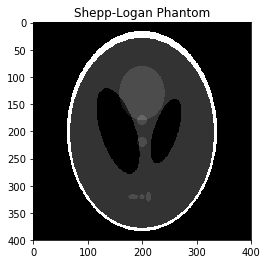

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = np.stack((np.real(image), np.imag(image)))
image = torch.tensor(image).to(dtype).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 2, 400, 400])


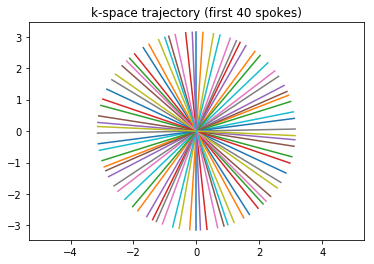

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
ktraj = torch.tensor(ktraj).to(dtype).unsqueeze(0)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([1, 2, 324000])


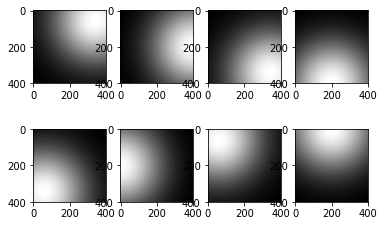

In [6]:
# simulate some sensitivity coils (no phase for simplicity)
ncoil = 8
smap = np.absolute(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.absolute(smap[i]))
plt.gray()
    
plt.show()

In [7]:
# convert smaps to tensors, unsqueeze batch dimension
smap = np.stack((np.real(smap), np.imag(smap)), axis=1)
smap = torch.tensor(smap).to(dtype).unsqueeze(0)

In [8]:
# build sense-nufft operators
sensenufft_ob = MriSenseNufft(smap=smap, im_size=im_size, grid_size=grid_size).to(dtype)
adjsensenufft_ob = AdjMriSenseNufft(smap=smap, im_size=im_size, grid_size=grid_size).to(dtype)
toep_ob = ToepSenseNufft(smap=smap)

dcomp = calculate_radial_dcomp_pytorch(sensenufft_ob, adjsensenufft_ob, ktraj).unsqueeze(0).unsqueeze(0)

print(sensenufft_ob)
print(adjsensenufft_ob)
print(toep_ob)


MriSenseNufft
----------------------------------------
   training: True
   im_size: (400, 400)
   grid_size: (800, 800)
   n_shift: (200, 200)
   numpoints: (6, 6)
   alpha: (14.04, 14.04)
   order: (0, 0)
   table: 2 arrays, lengths: (1024, 1024)
   scaling_coef: (400, 400) float64 array
   norm: None
   coil_broadcast: False
   coilpack: False
   matadj: False
   smap_shape: torch.Size([1, 8, 2, 400, 400])


AdjMriSenseNufft
----------------------------------------
   training: True
   im_size: (400, 400)
   grid_size: (800, 800)
   n_shift: (200, 200)
   numpoints: (6, 6)
   alpha: (14.04, 14.04)
   order: (0, 0)
   table: 2 arrays, lengths: (1024, 1024)
   scaling_coef: (400, 400) float64 array
   norm: None
   coil_broadcast: False
   coilpack: False
   matadj: False
   smap_shape: torch.Size([1, 8, 2, 400, 400])


ToepSenseNufft
----------------------------------------
   training: True
   smap_shape: torch.Size([1, 8, 2, 400, 400])



In [9]:
# calculate the Toeplitz kernel with and without density compensation
normal_kern = calc_toep_kernel(adjsensenufft_ob, ktraj)  # without density compensation
dcomp_kern = calc_toep_kernel(adjsensenufft_ob, ktraj, weights=dcomp)  # with density compensation

In [10]:
# run a forward/backward the normal way without dcomp
start_normal_blurry = time.perf_counter()
image_blurry = adjsensenufft_ob(sensenufft_ob(image, ktraj), ktraj)
end_normal_blurry = time.perf_counter()

# run a forward/backward the normal way with dcomp
start_normal_sharp = time.perf_counter()
image_sharp = adjsensenufft_ob(dcomp * sensenufft_ob(image, ktraj), ktraj)
end_normal_sharp = time.perf_counter()

# run a forward/backward with Toeplitz without dcomp
start_toep_blurry = time.perf_counter()
image_blurry_toep = toep_ob(image, normal_kern)
end_toep_blurry = time.perf_counter()

# run a forward/backward with Toeplitz with dcomp
start_toep_sharp = time.perf_counter()
image_sharp_toep = toep_ob(image, dcomp_kern)
end_toep_sharp = time.perf_counter()

In [11]:
# print the timings and normalized differences
# blurry (no density compensation)
print('forward/backward without dcomp, normal time: {}, toeplitz time: {}'.format(
    end_normal_blurry-start_normal_blurry, end_toep_blurry-start_toep_blurry))
normdiff_blurry = torch.norm(image_blurry-image_blurry_toep)/torch.norm(image_blurry)
print('normalized difference: {}'.format(normdiff_blurry))

# sharp (with density compensation)
print('forward/backward with dcomp, normal time: {}, toeplitz time: {}'.format(
    end_normal_sharp-start_normal_sharp, end_toep_sharp-start_toep_sharp))
normdiff_sharp = torch.norm(image_sharp-image_sharp_toep)/torch.norm(image_sharp)
print('normalized difference: {}'.format(normdiff_sharp))

forward/backward without dcomp, normal time: 5.099121120001655, toeplitz time: 0.1101371530094184
normalized difference: 2.4606042643426917e-06
forward/backward with dcomp, normal time: 4.659421695017954, toeplitz time: 0.13685655701556243
normalized difference: 3.695836994666024e-06


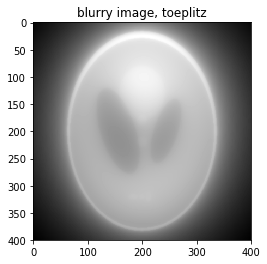

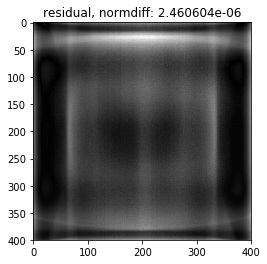

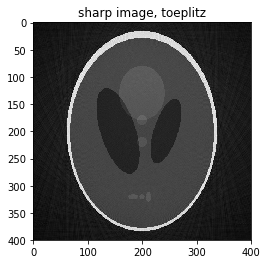

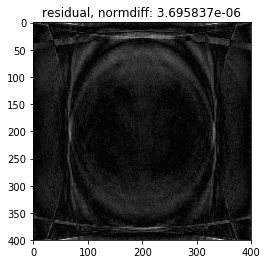

In [12]:
# show the images from the toeplitz results with residuals to normal
image_blurry_numpy = np.squeeze(image_blurry.numpy())
image_blurry_numpy = image_blurry_numpy[0] + 1j*image_blurry_numpy[1]

image_sharp_numpy = np.squeeze(image_sharp.numpy())
image_sharp_numpy = image_sharp_numpy[0] + 1j*image_sharp_numpy[1]

image_blurry_numpy_toep = np.squeeze(image_blurry_toep.numpy())
image_blurry_numpy_toep = image_blurry_numpy_toep[0] + 1j*image_blurry_numpy_toep[1]

image_sharp_numpy_toep = np.squeeze(image_sharp_toep.numpy())
image_sharp_numpy_toep = image_sharp_numpy_toep[0] + 1j*image_sharp_numpy_toep[1]

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy_toep))
plt.gray()
plt.title('blurry image, toeplitz')

plt.figure(1)
plt.imshow(np.absolute(image_blurry_numpy_toep - image_blurry_numpy))
plt.gray()
plt.title('residual, normdiff: {:.6e}'.format(normdiff_blurry))

plt.figure(2)
plt.imshow(np.absolute(image_sharp_numpy_toep))
plt.gray()
plt.title('sharp image, toeplitz')

plt.figure(3)
plt.imshow(np.absolute(image_sharp_numpy_toep - image_sharp_numpy))
plt.gray()
plt.title('residual, normdiff: {:.6e}'.format(normdiff_sharp))

plt.show()